In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
from pandas.tools.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf

/usr/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dat = pd.read_csv('data.csv')
dat['date'] = pd.to_datetime(dat['date']);
dat.set_index('date');

## Raw time series:

<IPython.core.display.Javascript object>


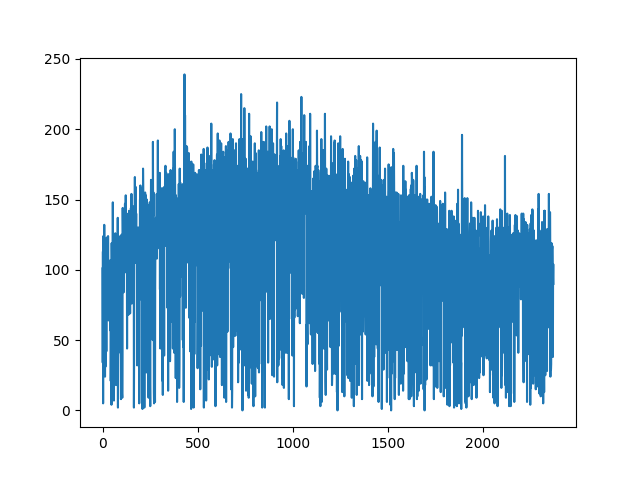

In [4]:
dat['car.count'].plot()

## Periodogram:

* To model this time series we need to convert it into a stationary process
* This requires de-trending and removing any cyclical components
* Are there any obvious periodic (e.g. weekly) patterns?
    - The power spectral density of the differenced time series indicates **no**. That will simplify our modeling.

In [5]:
cc = dat['car.count']
x = np.array(range(len(np.array(cc))))
f, spectral_density = signal.periodogram(np.array(cc))

<IPython.core.display.Javascript object>


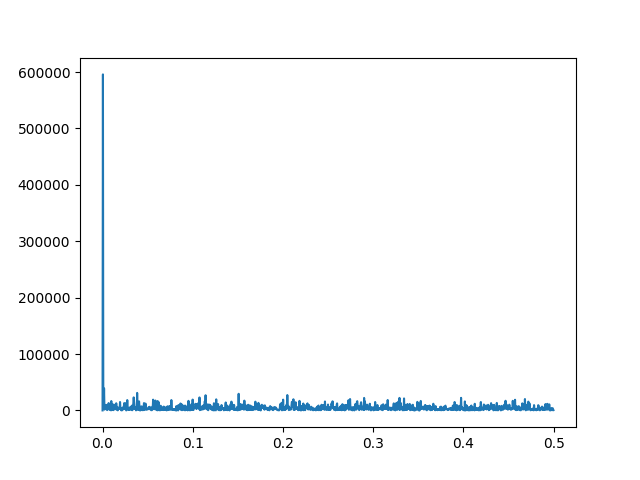

In [7]:
plt.plot(f, spectral_density)

## Autocorrelation and partial autocorrelation plots:

Summary:

 * The slow decay of the autocorrelation is an autogregressive signature
     - As is the sharp decline of the partial autocorrelation (PACF) beyond a lag of 1
     - The PACF value at lag 1 gives the AR(1) coefficient. Since it's equal to 1, adding an AR term to the model for this series is equivalent to differencing it.
     

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


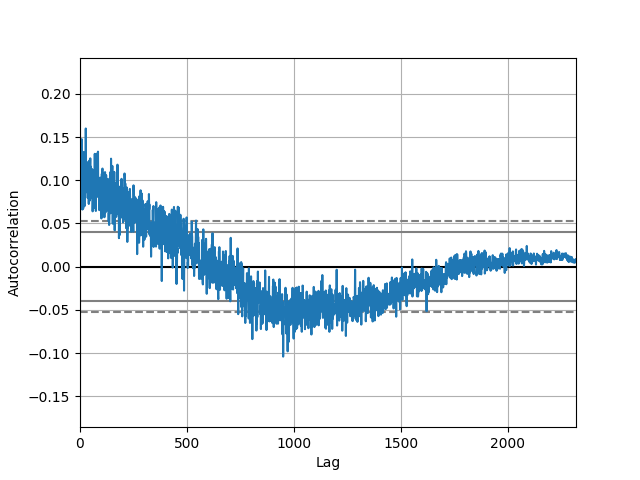

In [10]:
autocorrelation_plot(dat['car.count'])

<IPython.core.display.Javascript object>


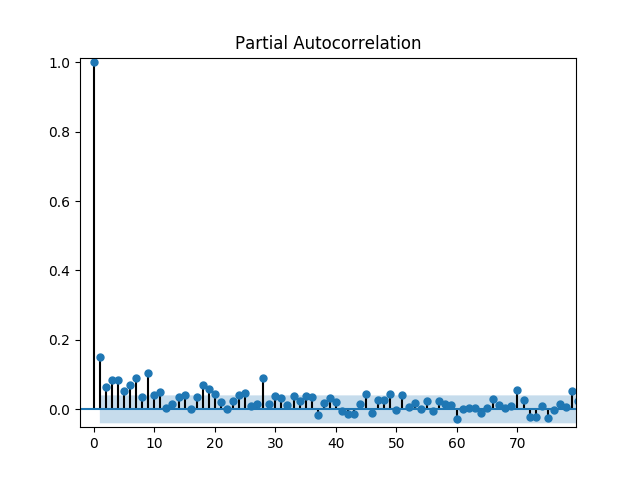

<IPython.core.display.Javascript object>


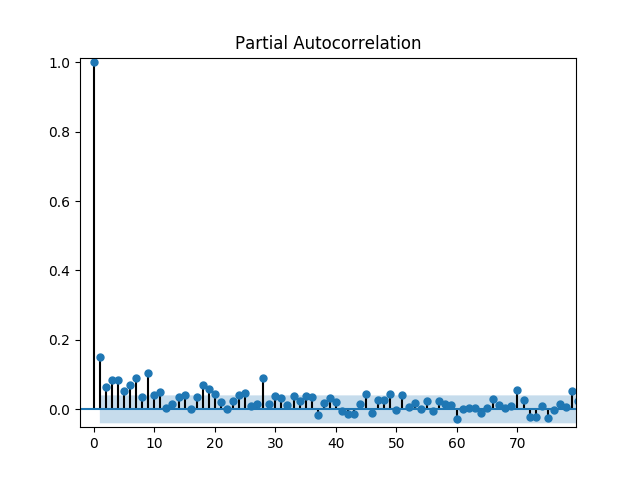

In [10]:
plot_pacf(dat['car.count'])

## Autocorrelation of the differenced series

 * Negative value of the lag-1 autocorrelation indicates need for a MA term
 

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


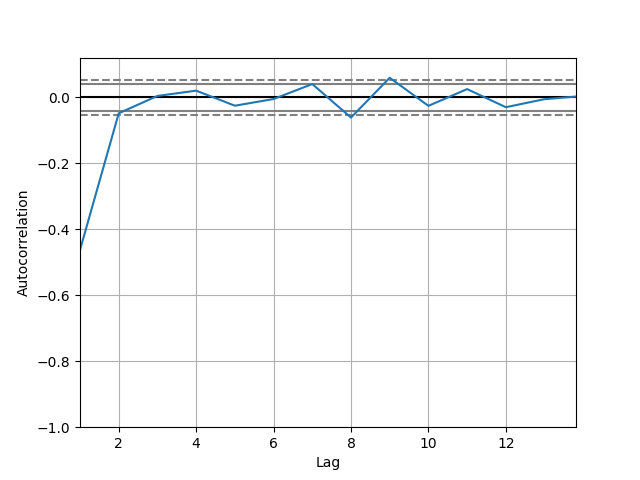

In [79]:
autocorrelation_plot(np.diff(dat['car.count']))

## Time-series modeling summary

* ARMA(1, 1) looks like a potentially OK description of this process
* (would have to actually fit the model to substantiate the above statement, naturally...)

# Multiple regression

* For crude exploratory purposes, let's pretend that AR(1) is a good model for the time series (i. e., residuals to the fit are white noise)
* We can therefore regress the differenced data over the variables 'weather' and 'cloud.indicator' to see whether either or both have predictive value (putting aside the time series component of this problem)
 - For 'cloud.indicator', which is a categorical variable, we encode 'clear' as 0 and 'cloudy' as 1

In [35]:
cl = dat['cloud.indicator']

In [38]:
weather = dat['weather']
dat['cloud.indicator'] = cl.map(lambda s: 0. if s == 'clear' else 1.)
cars = dat['car.count']

In [58]:
X = dat[['weather', 'cloud.indicator']]
y = cars.diff()
y[0] = 0.

In [59]:
estimate = sm.OLS(y, X).fit()

In [60]:
estimate.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              car.count   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     210.5
Date:                Thu, 30 Nov 2017   Prob (F-statistic):           7.17e-85
Time:                        20:27:30   Log-Likelihood:                -13092.
No. Observations:                2373   AIC:                         2.619e+04
Df Residuals:                    2371   BIC:                         2.620e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
weather            -1.1487      1.228     -0.936      0.350      -3.557       1.259
cloud.indicator   -38.6642      1.886    -20.497      0.000     -42.363     -34.965
==============================================================================
Omnibus:                       27.384   Durbin-Watson:                   2.597
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.133
Skew:                           0.267   Prob(JB):                     7.78e-07
Kurtosis:                       3.009   Cond. No.                         1.54
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Multiple regression summary

* The feature 'weather' has no predictive value
* 'cloud.indicator' does (with very strong statistical significance)

# Conclusions

* Next step (if I were to spend more time on this problem) would be to model the time series as an ARMA(1, 1) process with the floating point encoding of 'cloud.indicator' added as an additional regressor
    - i.e., ARMAX with one exogenous input
* Forecasting is straightforward under this model, and computationally cheap!
* We can use the implementation in statsmodels.tsa.arima_model.ARMA